## CNN for t=1 to t=20
Taking first three convolutional and pooling layers (first three blocks) of VGG16. In the final block extract the final convolutional layer and add on top of the network the following layers:
1. Batch normalization
2. Global average pooling
3. Latent vector
4. Batch normalization (size 32 - this is the feature vector for use in the time-series modelling)
5. RELU activation
6. Final dense layer of size 1 (with a sigmoid activation for classification mode and no activation when in prediction/regression mode).


### Modelling info
5 fold cross-validation on training data. Binary cross-entropy loss for classification and MSE loss for the regressor along with the Adam optimizer (with a learning rate of 0.001). Batch size of 32. Training for 50 epochs with the base model frozen. 50 epochs was sufficient for convergence. Unfreezing the base after and training for more epochs did not lower the validation loss, so here the base is kept frozen. 90 degree rotations and mirroring were used to augment the training data to 8 times its size. Augmentation was also used on the validation data (and will also be used in the end, in later notebooks, on the test data). Save best weights as go along and best model at the end.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import re
import glob
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers import Dense, Flatten, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import RMSprop, Adam
from keras import backend as K
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from datetime import datetime

In [4]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]

In [5]:
def plot_history(model_history, model_name, fit_method):
    fig = plt.figure(figsize=(8,5), facecolor='w')
    ax = fig.add_subplot(111)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    plt.close()

In [6]:
def get_image(path, stats, rescale_method):
    img = np.load(path)
    img = img.astype('float32')
    return img

In [7]:
def get_gfp(path, stats, rescale_method, fit_method, gfp_thresh):
    gfp = np.load(path)
    if fit_method == 'classify':
        if gfp <= gfp_thresh:
            res = 0.
        else:
            res = 1.
    if fit_method == 'regress':
        if rescale_method == 'log':
            res = np.log(gfp)
        if rescale_method == 'log_center':
            res = np.log(gfp) - np.log(stats[2])
        if rescale_method == 'normalize':
            res = (gfp - stats[0])/(stats[1] - stats[0])
        if rescale_method == 'standardize':
            res = (gfp - stats[2])/stats[3]
        if rescale_method == 'log_normalize':
            res = (np.log(gfp) - np.log(stats[0]))/(np.log(stats[1]) - np.log(stats[0]))
        if rescale_method == 'log_standardize':
            res = (np.log(gfp) - np.log(stats[2]))/np.log(stats[3])
    return res

In [8]:
def rotate90xDegrees(img):
    ret =[]
    rows, cols = img.shape
    for i in range(1,4):
        M = cv2.getRotationMatrix2D((cols/2,rows/2),i*90,1)
        ret.append(cv2.warpAffine(img,M,(cols,rows)))
    return ret

In [9]:
def augment_image(img, aug_no):
    img_new = np.zeros((img.shape)).astype('float32')
    rows, cols, chans = img.shape
    for i in range(chans):
        if aug_no == 0:
            img_new[:, :, i] = img[:, :, i]
        if aug_no == 1:
            img_new[:, :, i] = np.flipud(img[:, :, i])
        if aug_no == 2:
            img_new[:, :, i] = np.fliplr(img[:, :, i])
        if aug_no == 3:
            ud = np.flipud(img[:, :, i])
            img_new[:, :, i] = np.fliplr(ud)
        if aug_no == 4:
            img_new[:, :, i] = rotate90xDegrees(img[:, :, i])[0]
        if aug_no == 5:
            ud = np.flipud(img[:, :, i])
            img_new[:, :, i] = rotate90xDegrees(ud)[0]
        if aug_no == 6:
            lr = np.fliplr(img[:, :, i])
            img_new[:, :, i] = rotate90xDegrees(lr)[0]
        if aug_no == 7:
            ud = np.flipud(img[:, :, i])
            udlr = np.fliplr(ud)
            img_new[:, :, i] = rotate90xDegrees(udlr)[0]
    
    return img_new

In [10]:
def image_generator(cell_files, gfp_files, batch_size, cell_stats, gfp_stats, 
                          cell_rescale_method, gfp_rescale_method, fit_method):
    while True:
        # Select files (paths/indices) for the batch
        samp = np.random.choice(np.arange(0, len(cell_files)), size=batch_size, replace=False)
        batch_paths_in =  [cell_files[index] for index in samp]
        batch_paths_out = [gfp_files[index] for index in samp]
        batch_input = []
        batch_output = []
        aug_nums = np.random.randint(0, 8, batch_size)
        
        for ii, image_path in enumerate(batch_paths_in):
            img = get_image(image_path, stats=cell_stats, rescale_method=cell_rescale_method)
            aug_no = aug_nums[ii]
            img = augment_image(img, aug_no=aug_no)
            batch_input += [img]
        
        for ii, path in enumerate(batch_paths_out):
            target = get_gfp(path, stats=gfp_stats, rescale_method=gfp_rescale_method, 
                             fit_method=fit_method, gfp_thresh=gfp_stats[4])
            batch_output += [target]
        
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)
        
        if fit_method == 'classify':
            batch_y = batch_y.astype('int64')
        
        yield batch_x, batch_y

### Data and modelling settings

In [11]:
fold = 'fold5' # this is the validation fold, all cells not in this fold used for proper training
unfreeze_base = 'False'

all_cell_dir = '/scratch-shared/phil/LNP/LNP_data_09/images_train'
all_cell = glob.glob(all_cell_dir + '/' '*')
all_cell = sorted(all_cell, key = natural_keys)
all_gfp_dir = '/scratch-shared/phil/LNP/LNP_data_09/gfp_train'

train_cell = []
train_gfp = []

valid_cell = []
valid_gfp = []

for cell in all_cell:
    s0 = cell.split('train/')
    s1 = s0[1].split('_')
    if s1[0] == fold:
        valid_cell.append(cell)
        f = glob.glob(all_gfp_dir + '/' + s1[1] + '_' + s1[2] + '_T0072_cell_' + s1[5])
        valid_gfp.extend(f)
    else:
        train_cell.append(cell)
        f = glob.glob(all_gfp_dir + '/' + s1[1] + '_' + s1[2] + '_T0072_cell_' + s1[5])
        train_gfp.extend(f)


fit_method = 'regress' # 'classify' or 'regress'
# previous explorations showed the following two rescaling methods to be the most appropriate
cell_rescale_method = 'standardize'
gfp_rescale_method = 'log_center'
cell_stats = np.load('/scratch-shared/phil/LNP/LNP_data_09/cell_stats.npy')
gfp_stats = np.load('/scratch-shared/phil/LNP/LNP_data_09/gfp_stats.npy')

# getting class weights for when in classification mode
if fit_method == 'classify':
    class_gfp = []
    for cell in train_gfp:
        gfp = get_gfp(cell, stats=gfp_stats, rescale_method=gfp_rescale_method, 
                      fit_method=fit_method, gfp_thresh=gfp_stats[4])
        class_gfp = np.append(class_gfp, gfp)
    class_gfp = class_gfp.astype('int64')
    weights = class_weight.compute_class_weight('balanced', np.unique(class_gfp), class_gfp)
    print('weights = ' + str(weights))

save_best = keras.callbacks.ModelCheckpoint('best.weights', monitor='val_loss', verbose=0, save_best_only=True)
batch_size = 32
latent_dim = 32
num_epochs = 50
lr = 0.001

In [12]:
pretrained_model = VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(192, 192, 3))

base_model = Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer('block3_conv3').output)
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(latent_dim)(x)
x = BatchNormalization(name='latent_vector')(x)
x = Activation('relu')(x)
if fit_method == 'classify':
    predictions = Dense(1, activation='sigmoid')(x)
else:
    predictions = Dense(1)(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 192, 192, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 96, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 96, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 96, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 48, 128)       0         
__________

### Model fitting

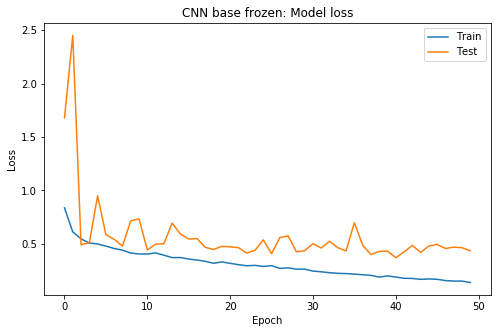

fold5 base frozen: min validation loss = 0.371


In [13]:
base_model.trainable = False

if fit_method == 'classify':
    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['acc'])
else:
    model.compile(optimizer=Adam(lr=lr), loss='mse')

if fit_method == 'classify':
    history = model.fit_generator(
        image_generator(train_cell, train_gfp, batch_size, cell_stats, gfp_stats, 
                        cell_rescale_method, gfp_rescale_method, fit_method),
        steps_per_epoch=len(train_cell) // batch_size,
        epochs = num_epochs,
        validation_data = image_generator(valid_cell, valid_gfp, batch_size, cell_stats, gfp_stats,
                                          cell_rescale_method, gfp_rescale_method, fit_method),
        validation_steps = len(valid_cell) // batch_size,
        callbacks = [save_best],
        class_weight = weights,
        verbose = 0
    )
else:
    history = model.fit_generator(
        image_generator(train_cell, train_gfp, batch_size, cell_stats, gfp_stats, 
                        cell_rescale_method, gfp_rescale_method, fit_method),
        steps_per_epoch=len(train_cell) // batch_size,
        epochs = num_epochs,
        validation_data = image_generator(valid_cell, valid_gfp, batch_size, cell_stats, gfp_stats,
                                          cell_rescale_method, gfp_rescale_method, fit_method),
        validation_steps = len(valid_cell) // batch_size,
        callbacks = [save_best],
        verbose = 0
    )  

plot_history(history, 'CNN base frozen', fit_method)
min_loss = np.round(np.min(history.history['val_loss']), 3)
print(fold + ' base frozen: min validation loss = ' + str(min_loss))

if unfreeze_base == 'True':   
    base_model.trainable = True

    if fit_method == 'classify':
        model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['acc'])
    else:
        model.compile(optimizer=Adam(lr=lr), loss='mse')

    if fit_method == 'classify':
        history = model.fit_generator(
            image_generator(train_cell, train_gfp, batch_size, cell_stats, gfp_stats, 
                            cell_rescale_method, gfp_rescale_method, fit_method),
            steps_per_epoch=len(train_cell) // batch_size,
            epochs = num_epochs,
            validation_data = image_generator(valid_cell, valid_gfp, batch_size, cell_stats, gfp_stats,
                                              cell_rescale_method, gfp_rescale_method, fit_method),
            validation_steps = len(valid_cell) // batch_size,
            callbacks = [save_best],
            class_weight = weights,
            verbose = 0
        )
    else:
        history = model.fit_generator(
            image_generator(train_cell, train_gfp, batch_size, cell_stats, gfp_stats, 
                            cell_rescale_method, gfp_rescale_method, fit_method),
            steps_per_epoch=len(train_cell) // batch_size,
            epochs = num_epochs,
            validation_data = image_generator(valid_cell, valid_gfp, batch_size, cell_stats, gfp_stats,
                                              cell_rescale_method, gfp_rescale_method, fit_method),
            validation_steps = len(valid_cell) // batch_size,
            callbacks = [save_best],
            verbose = 0
        )  

    plot_history(history, 'CNN base unfrozen', fit_method)
    min_loss = np.round(np.min(history.history['val_loss']), 3)
    print(fold + ' base unfrozen: min validation loss = ' + str(min_loss))

model.save('/scratch-shared/phil/LNP/LNP_data_09/CNN_' + fit_method + '_' + fold + '.h5')